# Making the Best of the Worst

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_glpk()

pyomo was previously installed
glpk was previously installed


True

## Problem

A common formulation for to maximize profit of a multi-product facility in a resource constrained  environment is given by the linear program

$$
\begin{align*}
\max\ \text{profit}  = \sum_{j\in J} c_j x_j &\\
\text{s.t.} \qquad \sum_{j\in J} a_{ij}x_j & \leq b_i & \forall i \in I\\
x_j & \geq 0 & \forall j\in J
\end{align*}
$$

where $x_j$ is the production of product $j\in J$, $c_j$ is the net profit from producing and selling one unit of product $j$, $a_{i, j}$ is the amount of resource $i$ required to product a unit of product $j$, and $b_i$ is amount of resource $i\in I$ available. If this data is available, then the linear programming solution can provide a considerable of information regarding an optimal production plan and the marginal value of additional resources.

But what if coefficients of the model are uncertain? What should be the objective then? Does uncertainty change the production plan? Does the uncertainty change the marginal value assigned to resources? These are complex and thorny questions that will be largely reserved for later chapters of this book. However, it is possible to consider a specific situation within the current context.

Consider a situation where is of $S$ plausible models for the net profit. These might be a result of marketing studies or from considering plant operation under multiple scenarios. The set of profit models could be written

$$
\begin{align*}
\text{profit}_s & = \sum_{j} c_j^s x_j & \forall s\in S
\end{align*}
$$

where $s$ indexes the set of possible scenarios. The scenarios are all deemed equal, no probabilistic interpretation is given. 

One conservative criterion is to find maximize profit for the worst case. Letting $z$ denote the profit for the worst case, this criterion requires finding a solution for ${x_j}$ for ${j\in J}$ that satisfies

$$
\begin{align*}
\max_{x_j} z & \\
\\
\text{s.t.} \qquad \sum_{j\in J} c_j^s x_j & \geq z& \forall ss\in S\\
\sum_{j\in J} a_{ij}x_j & \leq b_i & \forall i \in I\\
x_j & \geq 0 & \forall j\in J
\end{align*}
$$

where $z$ is lowest profit that would be encountered under any condition.


## Data

In [2]:
import pandas as pd

BIM_scenarios = pd.DataFrame([
    [12, 9], 
    [11, 10], 
    [8, 11]], 
    columns=["product 1", "product 2"])

BIM_scenarios.index.name = "scenarios"
print("\nProfit scenarios")
display(BIM_scenarios)

BIM_resources = pd.DataFrame([
    ["silicon", 1000, 1, 0],
    ["germanium", 1500, 0, 1],
    ["plastic", 1750, 1, 1],
    ["copper", 4000, 1, 2]],
    columns = ["resource", "available", "product 1", "product 2"])
BIM_resources = BIM_resources.set_index("resource")
    
print("\nAvailable resources and resource requirements")
display(BIM_resources)
    


Profit scenarios


,product 1,product 2
scenarios,,
0,12,9
1,11,10
2,8,11



Available resources and resource requirements


,available,product 1,product 2
resource,,,
silicon,1000,1,0
germanium,1500,0,1
plastic,1750,1,1
copper,4000,1,2


## Pyomo Model

An implementation of the maximum worst-case profit model.

In [3]:
import pyomo.environ as pyo

def maxmin(scenarios, resources):
    
    model    = pyo.ConcreteModel('BIM')
    
    products = resources.columns.tolist()
    products.remove('available')
    
    model.I = pyo.Set(initialize=resources.index)
    model.J = pyo.Set(initialize=products)
    model.S = pyo.Set(initialize=scenarios.index)
    
    model.a = pyo.Param(model.I, model.J, rule = lambda model, i, j: resources.loc[i, j])
    model.b = pyo.Param(model.I, rule = lambda model, i: resources.loc[i, "available"])
    model.c = pyo.Param(model.S, model.J, rule = lambda model, s, j: scenarios.loc[s, j])
    
    model.x = pyo.Var(model.J, domain=pyo.NonNegativeReals)
    model.z  = pyo.Var() 
    
    @model.Objective(sense=pyo.maximize)
    def profit(model):
        return model.z
    
    @model.Constraint(model.S)
    def scenario_profit(m, s):
        return m.z <= sum(model.c[s, j] * model.x[j] for j in model.J)
        
    @model.Constraint(model.I)
    def resource_limits(model, i):
        return sum(model.a[i, j] * model.x[j] for j in model.J) <= model.b[i]

    return model

BIM = maxmin(BIM_scenarios, BIM_resources)
pyo.SolverFactory('glpk').solve(BIM)

worst_case_plan = pd.Series({j: BIM.x[j]() for j in BIM.J}, name="worst case")
worst_case_profit = BIM.profit()

print("\nworst case profit = ", worst_case_profit)
print(f"\nworst case production plan:\n")
display(worst_case_plan)


worst case profit =  17500.0

worst case production plan:



product 1     583.333333
product 2    1166.666667
Name: worst case, dtype: float64

## Is maximizing the worst case a good idea?

Maximizing the worst case among all cases is a conservative planning outlook. It may be worth investigating alternative planning outlooks.

The first step is to create a model to optimize a single scenario. Without repeating the mathematical description, the following Pyomo model is simply the `maxmin` model adapted to a single scenario.

In [4]:
def max_profit(scenario, resources):
    
    model    = pyo.ConcreteModel('BIM')
    
    products = resources.columns.tolist()
    products.remove('available')
    
    model.I = pyo.Set(initialize=resources.index)
    model.J = pyo.Set(initialize=products)
    
    model.a = pyo.Param(model.I, model.J, rule = lambda model, i, j: resources.loc[i, j])
    model.b = pyo.Param(model.I, rule = lambda model, i: resources.loc[i, "available"])
    model.c = pyo.Param(model.J, rule = lambda model, j: scenario[j])
    
    model.x = pyo.Var(model.J, domain=pyo.NonNegativeReals)
    model.z  = pyo.Var() 
    
    @model.Objective(sense=pyo.maximize)
    def profit(m, s):
        return sum(model.c[j] * model.x[j] for j in model.J)
        
    @model.Constraint(model.I)
    def resource_limits(model, i):
        return sum(model.a[i, j] * model.x[j] for j in model.J) <= model.b[i]

    return model

## Optimizing for the mean scenario

The next cell computes the optimal plan for the mean scenario.

In [5]:
# create mean scenario
mean_case = max_profit(BIM_scenarios.mean(), BIM_resources)
pyo.SolverFactory('glpk').solve(mean_case)

mean_case_profit = mean_case.profit()
mean_case_plan = pd.Series({j: mean_case.x[j]() for j in mean_case.J}, name="mean case")

print("\nmean case profit", mean_case_profit)
print("\nmean case production plan\n")
print(mean_case_plan)


mean case profit 17833.333333333336

mean case production plan

product 1    1000.0
product 2     750.0
Name: mean case, dtype: float64


The expected profit under the mean scenario if 17,833 which is 333 greater than for the worst case. Also note the production plan is different.

Would plan should be preferred ... one that produces a guaranteed profit of 17,500 under all scenarios, or one that produces expected profit of 17,833?

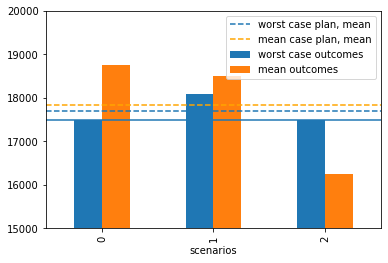

In [6]:
mean_case_outcomes = BIM_scenarios.dot(mean_case_plan)
mean_case_outcomes.name = "mean outcomes"

worst_case_outcomes = BIM_scenarios.dot(worst_case_plan)
worst_case_outcomes.name = "worst case outcomes"

ax = pd.concat([worst_case_outcomes, mean_case_outcomes], axis=1).plot(kind="bar", ylim=(15000, 20000))
ax.axhline(worst_case_profit)
ax.axhline(worst_case_outcomes.mean(), linestyle='--', label="worst case plan, mean")
ax.axhline(mean_case_outcomes.mean(), linestyle='--', color='orange', label="mean case plan, mean")
ax.legend()

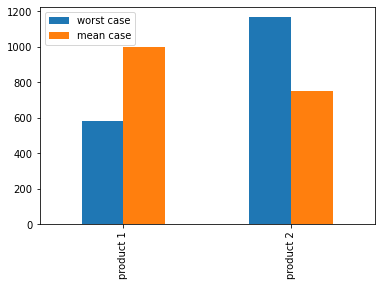

In [7]:
ax = pd.concat([worst_case_plan, mean_case_plan], axis=1).plot(kind="bar")

## Summary

Planning for the worst case reduces the penalty of a bad outcome. But it comes at the cost of reducing the expected payout, the also the maximum payout should the most favorable scenario occur.

1. Which plan would you choose.  Why?  

2. Make a case for the other choice.

